In [1]:
import pyterrier as pt
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as naf
from nlpaug.util import Action
import contractions
from pathlib import Path
from tqdm import tqdm

# Smaller dataset
dataset = pt.get_dataset("vaswani")

C:\Users\alexa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
expanded_texts = []
# Expand contractions for faster indexing
for doc in dataset.get_corpus_iter():
    if doc['text']:
        try:
            expanded_text = contractions.fix(doc['text'])
        except Exception as e:
            expanded_text = doc['text']  # Fallback to original text in case of error
        expanded_texts.append({'docno': doc['docno'], 'text': expanded_text})

print(expanded_texts[:5])  # Display the first 5 expanded texts

Java started (triggered by createCollection) and loaded: pyterrier.java, pyterrier.terrier.java [version=5.11 (build: craig.macdonald 2025-01-13 21:29), helper_version=0.0.8]


17:52:02.035 [main] WARN org.terrier.indexing.MultiDocumentFileCollection -- trec.encoding is not set; resorting to platform default (windows-1252). Indexing may be platform dependent. Recommend trec.encoding=UTF-8
[{'docno': '1', 'text': 'compact memories have flexible capacities  a digital data storage\nsystem with capacity up to bits and random and or sequential access\nis described'}, {'docno': '2', 'text': 'an electronic analogue computer for solving systems of linear equations\nmathematical derivation of the operating principle and stability\nconditions for a computer consisting of amplifiers'}, {'docno': '3', 'text': 'electronic coordinate transformer  circuit details are given for\nthe construction of an electronic calculating unit which enables\nthe polar coordinates of a vector modulus and cosine or sine of the\nargument to be derived from those of a rectangular system of axes'}, {'docno': '4', 'text': 'the british computer society  report of a conference held in cambridge\nj

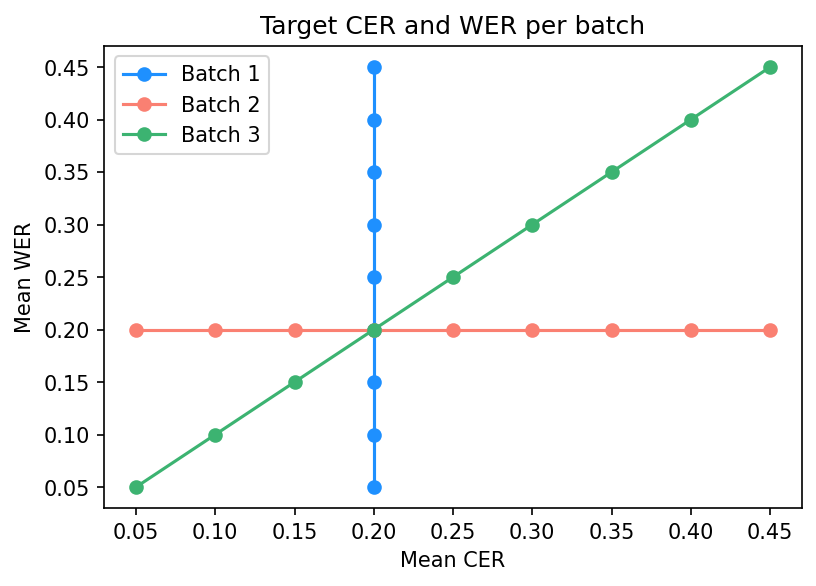

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Define data points
cer_values = np.arange(0.05, 0.5, 0.05)  # From 0.25 to 0.5 in steps of 0.05
wer_values = np.arange(0.05, 0.5, 0.05)  # Same for WER

# Fixed CER, increasing WER
cer_fixed = np.full_like(wer_values, 0.2)  # CER fixed at 0.25

# Fixed WER, increasing CER
wer_fixed = np.full_like(cer_values, 0.2)  # WER fixed at 0.25

# Plot
plt.figure(figsize=(6, 4), dpi=150)
plt.plot(cer_fixed, wer_values, 'o-', label="Batch 1", color="dodgerblue")
plt.plot(cer_values, wer_fixed, 'o-', label="Batch 2", color="salmon")
plt.plot(cer_values, wer_values, 'o-', label="Batch 3", color="mediumseagreen")

# Labels and title
plt.xlabel("Mean CER")
plt.ylabel("Mean WER")
plt.title("Target CER and WER per batch")
plt.legend()

# Remove grid
plt.grid(False)

# Show plot
plt.show()


In [ ]:
from pyterrier.measures import RR, nDCG, MAP
import pandas as pd


# THIS TAKES LONG TO RUN COMMENT OUT SOME OF THE COMBINATIONS TO TEST FASTER

# Define noise levels
noise_levels = [i * 0.05 for i in range(11)]  # Generates [0.0, 0.05, 0.1, ..., 0.5]

# Define different noise type proportions
noise_combinations = [
    {"sub": 1.0, "ins": 0.0, "del": 0.0},  # Only substitution
    {"sub": 0.0, "ins": 1.0, "del": 0.0},  # Only insertion
    {"sub": 0.0, "ins": 0.0, "del": 1.0},  # Only deletion
    {"sub": 0.5, "ins": 0.5, "del": 0.0},  # Substitution + Insertion
    {"sub": 0.5, "ins": 0.0, "del": 0.5},  # Substitution + Deletion
    {"sub": 0.0, "ins": 0.5, "del": 0.5},  # Insertion + Deletion
    {"sub": 0.33, "ins": 0.33, "del": 0.33},  # Equal mix
]

results = []

for noise_level in noise_levels:
    for noise_config in noise_combinations:
        # Set noise probabilities
        sub_prob = noise_level * noise_config["sub"]
        ins_prob = noise_level * noise_config["ins"]
        del_prob = noise_level * noise_config["del"]

        aug = naf.Sequential([
            nac.RandomCharAug(action="substitute", aug_char_p=0.25, aug_word_p=sub_prob, spec_char="", aug_char_min=0, aug_word_min=0, aug_char_max=500000, aug_word_max=500000),
            nac.RandomCharAug(action="insert", aug_char_p=0.25, aug_word_p=ins_prob, spec_char="", aug_char_min=0, aug_word_min=0, aug_char_max=500000, aug_word_max=500000),
            nac.RandomCharAug(action="delete", aug_char_p=0.25, aug_word_p=del_prob, aug_char_min=0, aug_word_min=0, aug_char_max=500000, aug_word_max=500000)
        ])

        # Apply noise to documents
        noisy_docs_list = []    
        for doc in expanded_texts:
            noisy_doc = aug.augment(doc['text'])
            if isinstance(noisy_doc, list):
                noisy_doc = " ".join(noisy_doc)
            noisy_docs_list.append({'docno': doc['docno'], 'text': noisy_doc})

        
        # Create index
        indexer = pt.IterDictIndexer(
            str(Path.cwd()),  # this will be ignored
            type=pt.index.IndexingType.MEMORY,
        )
        index_ref = indexer.index(iter(tqdm(noisy_docs_list)), fields=["text"])

        bm25 = pt.terrier.Retriever(index_ref, wmodel="BM25")

        # Run retrieval experiment
        eval_result = pt.Experiment(
            [bm25],
            dataset.get_topics(),
            dataset.get_qrels(),
            eval_metrics=[RR @ 10, nDCG @ 10, MAP @ 100]
        )

        # Store results
        eval_result["noise_level"] = noise_level
        eval_result["sub_prob"] = sub_prob
        eval_result["ins_prob"] = ins_prob
        eval_result["del_prob"] = del_prob
        results.append(eval_result)

# Combine results
final_results = pd.concat(results, ignore_index=True)
print(final_results)

100%|██████████| 11429/11429 [00:03<00:00, 2957.54it/s]

11:59:39.231 [main] WARN org.terrier.applications.batchquerying.TRECQuery -- trec.encoding is not set; resorting to platform default (windows-1252). Retrieval may be platform dependent. Recommend trec.encoding=UTF-8
11:59:39.243 [main] WARN org.terrier.querying.ApplyTermPipeline -- The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


KeyboardInterrupt: 

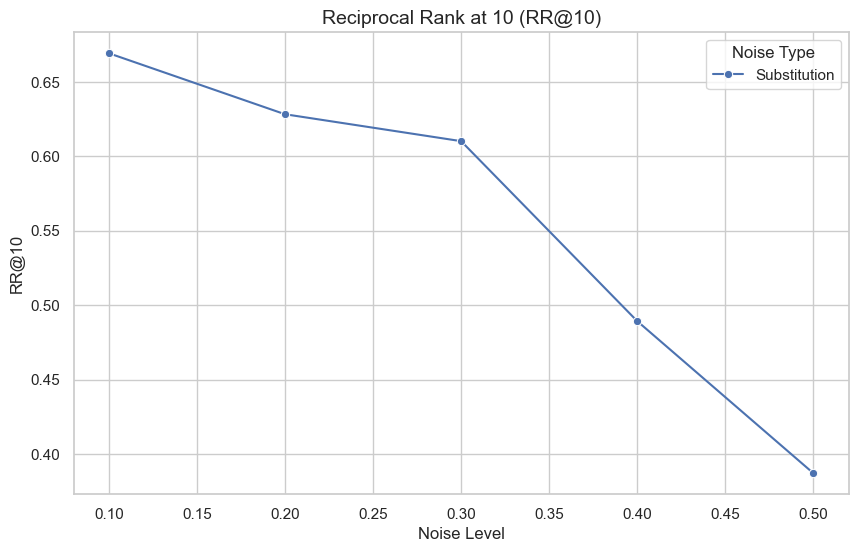

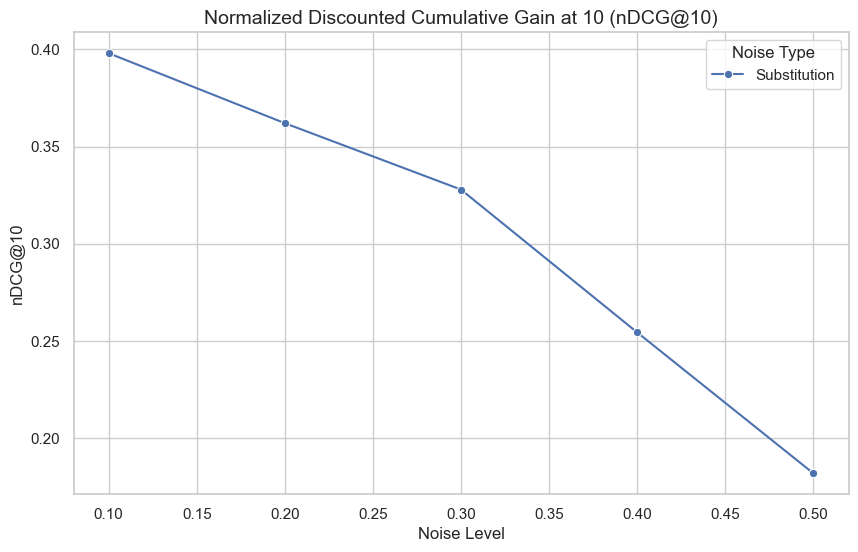

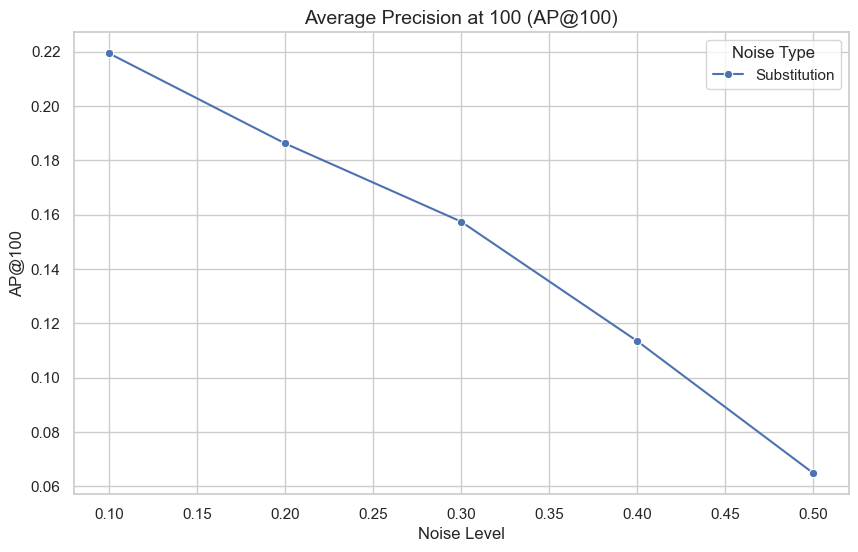

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

def get_noise_label(row):
    if row["sub_prob"] > 0 and row["ins_prob"] == 0 and row["del_prob"] == 0:
        return "Substitution"
    elif row["sub_prob"] == 0 and row["ins_prob"] > 0 and row["del_prob"] == 0:
        return "Insertion"
    elif row["sub_prob"] == 0 and row["ins_prob"] == 0 and row["del_prob"] > 0:
        return "Deletion"
    elif row["sub_prob"] > 0 and row["ins_prob"] > 0 and row["del_prob"] == 0:
        return "Substitution + Insertion"
    elif row["sub_prob"] > 0 and row["ins_prob"] == 0 and row["del_prob"] > 0:
        return "Substitution + Deletion"
    elif row["sub_prob"] == 0 and row["ins_prob"] > 0 and row["del_prob"] > 0:
        return "Insertion + Deletion"
    elif row["sub_prob"] == row["ins_prob"] == row["del_prob"] and row["sub_prob"] != 0 and row["ins_prob"] != 0 and row["del_prob"] != 0:
        return "Equal Mix"

final_results["Noise Type"] = final_results.apply(get_noise_label, axis=1)

sns.set(style="whitegrid")

def plot_metric(metric, title):
    plt.figure(figsize=(10, 6))
    sns.lineplot(
        data=final_results,
        x="noise_level",
        y=metric,
        hue="Noise Type",
        marker="o"
    )
    plt.title(title, fontsize=14)
    plt.xlabel("Noise Level", fontsize=12)
    plt.ylabel(metric, fontsize=12)
    plt.legend(title="Noise Type")
    plt.show()

plot_metric("RR@10", "Reciprocal Rank at 10 (RR@10)")
plot_metric("nDCG@10", "Normalized Discounted Cumulative Gain at 10 (nDCG@10)")
plot_metric("AP@100", "Average Precision at 100 (AP@100)")

In [13]:
datasets = {
    'fiqa': [],
    'fiqa-noisy-c': [],
    'fiqa-noisy-w': []
}
count = 0

aug_c = nac.RandomCharAug(aug_char_p=0.5, aug_word_p=0.1, action="substitute", aug_word_min=0, aug_word_max=50000000)
aug_w = nac.RandomCharAug(aug_char_p=0.1, aug_word_p=0.5, action="substitute", aug_word_min=0, aug_word_max=50000000)

for doc in dataset.get_corpus_iter():
    if doc['text'] == "":
        continue

    try :
        expanded = contractions.fix(doc['text'])
    except:
        expanded = doc['text']

    datasets['fiqa'].append({'docno': doc['docno'], 'text': expanded})
    datasets['fiqa-noisy-c'].append({'docno': doc['docno'], 'text': aug_c.augment(expanded)})
    datasets['fiqa-noisy-w'].append({'docno': doc['docno'], 'text': aug_w.augment(expanded)})


19:08:17.083 [main] WARN org.terrier.indexing.MultiDocumentFileCollection -- trec.encoding is not set; resorting to platform default (windows-1252). Indexing may be platform dependent. Recommend trec.encoding=UTF-8


In [14]:
# Indexing noisy documents - takes too long
from pathlib import Path
from tqdm import tqdm

indeces = {}

for key in datasets:
    indexer = pt.IterDictIndexer(
        str(Path.cwd()),  # this will be ignored
        type=pt.index.IndexingType.MEMORY,
    )
    index_ref = indexer.index(iter(tqdm(datasets[key])), fields=["text"])
    indeces[key] = index_ref

  0%|          | 0/11429 [00:00<?, ?it/s]

100%|██████████| 11429/11429 [03:19<00:00, 57.18it/s]


In [ ]:
# To test the noisy documents
from pyterrier.measures import RR, nDCG, MAP

bm25 = pt.terrier.Retriever(indeces['fiqa'], wmodel="BM25")
testset = pt.get_dataset("vaswani")
pt.Experiment(
    [bm25],
    testset.get_topics(),
    testset.get_qrels(),
    eval_metrics=[RR @ 10, nDCG @ 10, MAP @ 100],
)

KeyError: 'vaswani/test'

In [16]:
bm25 = pt.terrier.Retriever(indeces['fiqa-noisy-c'], wmodel="BM25")
pt.Experiment(
    [bm25],
    testset.get_topics(),
    testset.get_qrels(),
    eval_metrics=[RR @ 10, nDCG @ 10, MAP @ 100],
)

19:12:38.498 [main] WARN org.terrier.applications.batchquerying.TRECQuery -- trec.encoding is not set; resorting to platform default (windows-1252). Retrieval may be platform dependent. Recommend trec.encoding=UTF-8
19:12:38.530 [main] WARN org.terrier.querying.ApplyTermPipeline -- The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


,name,RR@10,nDCG@10,AP@100
0,TerrierRetr(BM25),0.664392,0.401595,0.227774


In [17]:
bm25 = pt.terrier.Retriever(indeces['fiqa-noisy-w'], wmodel="BM25")
pt.Experiment(
    [bm25],
    testset.get_topics(),
    testset.get_qrels(),
    eval_metrics=[RR @ 10, nDCG @ 10, MAP @ 100],
)

19:12:41.351 [main] WARN org.terrier.applications.batchquerying.TRECQuery -- trec.encoding is not set; resorting to platform default (windows-1252). Retrieval may be platform dependent. Recommend trec.encoding=UTF-8
19:12:41.374 [main] WARN org.terrier.querying.ApplyTermPipeline -- The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


,name,RR@10,nDCG@10,AP@100
0,TerrierRetr(BM25),0.37916,0.175117,0.06655
